In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates
import tensorflow as tf
import pandas as pd

In [10]:
df = pd.read_csv("/home/jose/Programming/aiml/Data/houston-AQI-weather/filled-in-data/Oyster Creek C1607.csv")

df.head(5)

,Unnamed: 0,Date,AQI,air_temp,dew_point_temp,sea_level_pressure,visibility,wind_speed
0,0,2017-01-01,31,20.121739,17.578261,1011.065217,13311.826087,2.618182
1,1,2017-01-02,39,22.243478,17.991304,1010.547826,13714.173913,4.960000
2,2,2017-01-03,45,17.178261,10.843478,1014.776190,11859.869565,2.457143
3,3,2017-01-04,16,11.856522,5.769565,1018.547826,16093.000000,4.136364
4,4,2017-01-05,11,12.904348,9.900000,1013.213043,14833.652174,3.000000


In [12]:
x_axis = (matplotlib.dates.datestr2num(df.Date.values))

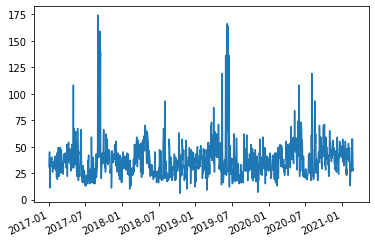

In [15]:
plt.plot_date(x_axis, df.AQI.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

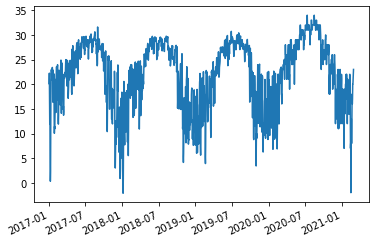

In [16]:
plt.plot_date(x_axis, df.air_temp.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

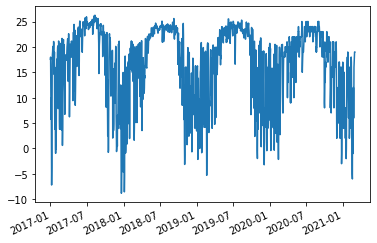

In [17]:
plt.plot_date(x_axis, df.dew_point_temp.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()